The necessary imports are done, as follows:

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, NuSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

The 'credit_card_approval.csv' is read using pandas, and stored in df.

In [2]:
df = pd.read_csv('credit_card_approval.csv')

In [3]:
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,JOB,BEGIN_MONTHS,STATUS,TARGET
0,5065438,F,Y,N,2+ children,270000.0,Secondary / secondary special,Married,With parents,-13258,-2300,1,0,0,0,Managers,-6,C,0
1,5142753,F,N,N,No children,81000.0,Secondary / secondary special,Single / not married,House / apartment,-17876,-377,1,1,1,0,Private service staff,-4,0,0
2,5111146,M,Y,Y,No children,270000.0,Higher education,Married,House / apartment,-19579,-1028,1,0,1,0,Laborers,0,C,0
3,5010310,F,Y,Y,1 children,112500.0,Secondary / secondary special,Married,House / apartment,-15109,-1956,1,0,0,0,Core staff,-3,0,0
4,5010835,M,Y,Y,2+ children,139500.0,Secondary / secondary special,Married,House / apartment,-17281,-5578,1,1,0,0,Drivers,-29,0,0


### Cleaning Data

Since pandas already provides a column that uniquely identifies rows, the ID column becomes redundant. Therefore, it can be effectively removed.

In [4]:
df = df.drop(columns=['ID'])
df.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,JOB,BEGIN_MONTHS,STATUS,TARGET
0,F,Y,N,2+ children,270000.0,Secondary / secondary special,Married,With parents,-13258,-2300,1,0,0,0,Managers,-6,C,0
1,F,N,N,No children,81000.0,Secondary / secondary special,Single / not married,House / apartment,-17876,-377,1,1,1,0,Private service staff,-4,0,0
2,M,Y,Y,No children,270000.0,Higher education,Married,House / apartment,-19579,-1028,1,0,1,0,Laborers,0,C,0
3,F,Y,Y,1 children,112500.0,Secondary / secondary special,Married,House / apartment,-15109,-1956,1,0,0,0,Core staff,-3,0,0
4,M,Y,Y,2+ children,139500.0,Secondary / secondary special,Married,House / apartment,-17281,-5578,1,1,0,0,Drivers,-29,0,0


Also, the DAYS_BIRTH column may not prove to be very useful in the dataset, as it gives the number of days since the person was born. This is convered to the person's age, which is a smaller and easier value for the classifier to work with. This conversion is done by performing floor division on the values in the DAYS_BIRTH column.

In [5]:
df['DAYS_BIRTH'] = (df['DAYS_BIRTH'] * -1) // 365
df.rename(columns = {'DAYS_BIRTH':'AGE'}, inplace = True)

A LabelEncoder() is then used to convert all categorical data in the dataframe to a numerical value.
The mappings of the actual value and the encoded value are stored in the mappings dictionary, and is later used by the GUI to encode responses in order to do a prediction.

In [6]:
mappings = {}
for col in df:
    if df[col].dtype == 'O':
        col_names = df[col].unique()
        encoder = LabelEncoder()
        df[col] = encoder.fit_transform(df[col])
        mappings[col] = (list(col_names), list(df[col].unique()))
df.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,AGE,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,JOB,BEGIN_MONTHS,STATUS,TARGET
0,0,1,0,1,270000.0,4,1,5,36,-2300,1,0,0,0,10,-6,6,0
1,0,0,0,2,81000.0,4,3,1,48,-377,1,1,1,0,12,-4,0,0
2,1,1,1,2,270000.0,1,1,1,53,-1028,1,0,1,0,8,0,6,0
3,0,1,1,0,112500.0,4,1,1,41,-1956,1,0,0,0,3,-3,0,0
4,1,1,1,1,139500.0,4,1,1,47,-5578,1,1,0,0,4,-29,0,0


### Training and Testing Sets

SMOTE and RandomUnderSampler are stored in the variables 'sm' and 'under'.

In [7]:
sm = SMOTE(sampling_strategy=0.25)
under = RandomUnderSampler(sampling_strategy=0.7)

The set of features are extracted from the dataset and are stored in X. This would include all columns except the TARGET column.

The set of labels are also extracted from the dataset and are stored in y. This would include the values from the TARGET column.

In [8]:
X = df.drop(columns=['TARGET']).copy()
X = np.array(X)
y = df['TARGET']

A stratified train-test split is done on X and y, giving x_train, x_test, y_train, y_test.

In [9]:
x_train, x_test, y_train, y_test = train_test_split(X,y, stratify=y)

The data is then passed through SMOTE and RandomUndrSampler in order to balance out the number of each type of label being used to train the classifer. This is done to eliminate any sort of bias that may be developed during training as a result of an unbalanced dataset.

In [10]:
x_train_res, y_train_res = sm.fit_resample(x_train, y_train.ravel())
x_train_res, y_train_res = under.fit_resample(x_train_res, y_train_res.ravel())

The proportions of labels in the dataset are shown before and after using SMOTE and RandomUnderSampler.

In [11]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 1471
Before OverSampling, counts of label '0': 401779 

After OverSampling, counts of label '1': 100444
After OverSampling, counts of label '0': 143491


This data is now used to train several different classifiers.

### Oversampling and Undersampling with Logistic Regression

In [12]:
clf_logreg = LogisticRegression(max_iter=500)
clf_logreg.fit(x_train_res, y_train_res)
y_pred_logreg = clf_logreg.predict(x_test)

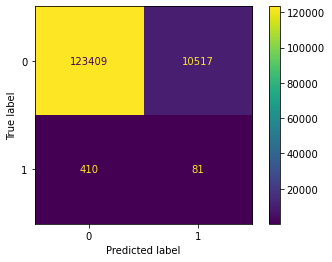

In [13]:
plot_confusion_matrix(clf_logreg, x_test, y_test, values_format = '.0f')
plt.show()

In [14]:
print("Accuracy Score: ", accuracy_score(y_test, y_pred_logreg))
print("F1 Score: ", f1_score(y_test, y_pred_logreg))

Accuracy Score:  0.9187081991117195
F1 Score:  0.014609072053386237


### Oversampling and Undersampling with LinearSVC

In [15]:
clf_svm = LinearSVC(max_iter=1000)
clf_svm.fit(x_train_res, y_train_res)
y_pred_svm = clf_svm.predict(x_test)

C:\Users\Timothy\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


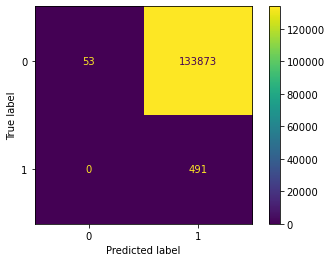

In [16]:
plot_confusion_matrix(clf_svm, x_test, y_test, values_format = '.0f')
plt.show()

In [17]:
print("Accuracy Score: ", accuracy_score(y_test, y_pred_svm))
print("F1 Score: ", f1_score(y_test, y_pred_svm))

Accuracy Score:  0.0040471071367460965
F1 Score:  0.007281895369100145


### Oversampling and Undersampling with Gaussian Naive Bayes

In [18]:
clf_gnb = GaussianNB()
clf_gnb.fit(x_train_res, y_train_res)
y_pred_gnb = clf_gnb.predict(x_test)

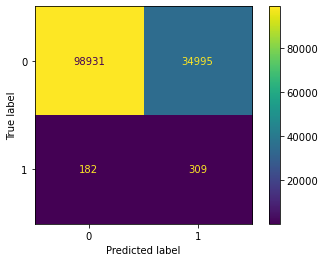

In [19]:
plot_confusion_matrix(clf_gnb, x_test, y_test, values_format = '.0f')
plt.show()

In [20]:
print("Accuracy Score: ", accuracy_score(y_test, y_pred_gnb))
print("F1 Score: ", f1_score(y_test, y_pred_gnb))

Accuracy Score:  0.7382994710490488
F1 Score:  0.017264981142617684


### Oversampling and Undersampling with Random Forest Classifier

In [21]:
clf_rf = RandomForestClassifier(n_estimators=50)
clf_rf.fit(x_train_res, y_train_res)
y_pred_rf = clf_rf.predict(x_test)

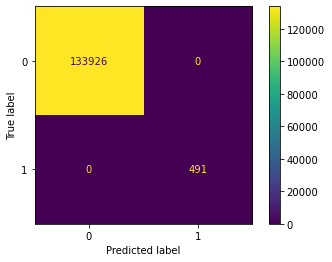

In [22]:
plot_confusion_matrix(clf_rf, x_test, y_test, values_format = '.0f')
plt.show()

In [23]:
print("Accuracy Score: ", accuracy_score(y_test, y_pred_rf))
print("F1 Score: ", f1_score(y_test, y_pred_rf))

Accuracy Score:  1.0
F1 Score:  1.0


### Testing 

In this section, random values for features are passed into the RandomTreeClassifier model and the results are obtained.

In [25]:
random_sample1 = [[0,1,0,1,90000,1,1,1,35,2000,1,1,0,0,10,-4,1]]
pred = clf_rf.predict(random_sample1)
pred

array([0], dtype=int64)

In [26]:
random_sample2 = [[1,1,1,1,40000,3,1,1,48,400,1,1,1,1,8,-2,4]]
pred2 = clf_rf.predict(random_sample2)
pred2

array([1], dtype=int64)

### Discussion

Bar plots are contructed in order to compare the accuracy and F1 scores of each classifer.

In [27]:
names = ['LR', 'SVC', 'GNB', 'RFC']
accuracies = pd.DataFrame([[0.95, 0.0036, 0.6958, 0.9999]], columns=names)
f1s = pd.DataFrame([[0.0164, 0.0072, 0.0124, 0.9989]], columns=names)
colors = ["#365d8b", "#3fad76", "#fde724", "#440154"]

Text(0, 0.5, 'Accuracy')

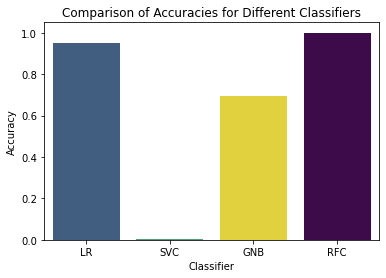

In [28]:
acc_plot = sns.barplot(data=accuracies, palette=colors)
acc_plot.set_title("Comparison of Accuracies for Different Classifiers")
acc_plot.set_xlabel("Classifier")
acc_plot.set_ylabel("Accuracy")

Text(0, 0.5, 'F1 Score')

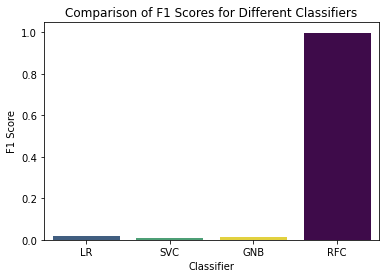

In [29]:
f1_plot = sns.barplot(data=f1s, palette=colors)
f1_plot.set_title("Comparison of F1 Scores for Different Classifiers")
f1_plot.set_xlabel("Classifier")
f1_plot.set_ylabel("F1 Score")